In [ ]:
%reset -f

In [4]:
# Set to false if working on local env
onColab = False

model_path = './e2d2_tel288'

# Decide batch size and validation split
batch_size = 512
validation_split = 0.2
test_split = 0.05
epochs = 400

dataset_path = './Training.csv'

window = 1000
stride = 10
# 864 / 16
telescope = 288

In [5]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [6]:
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


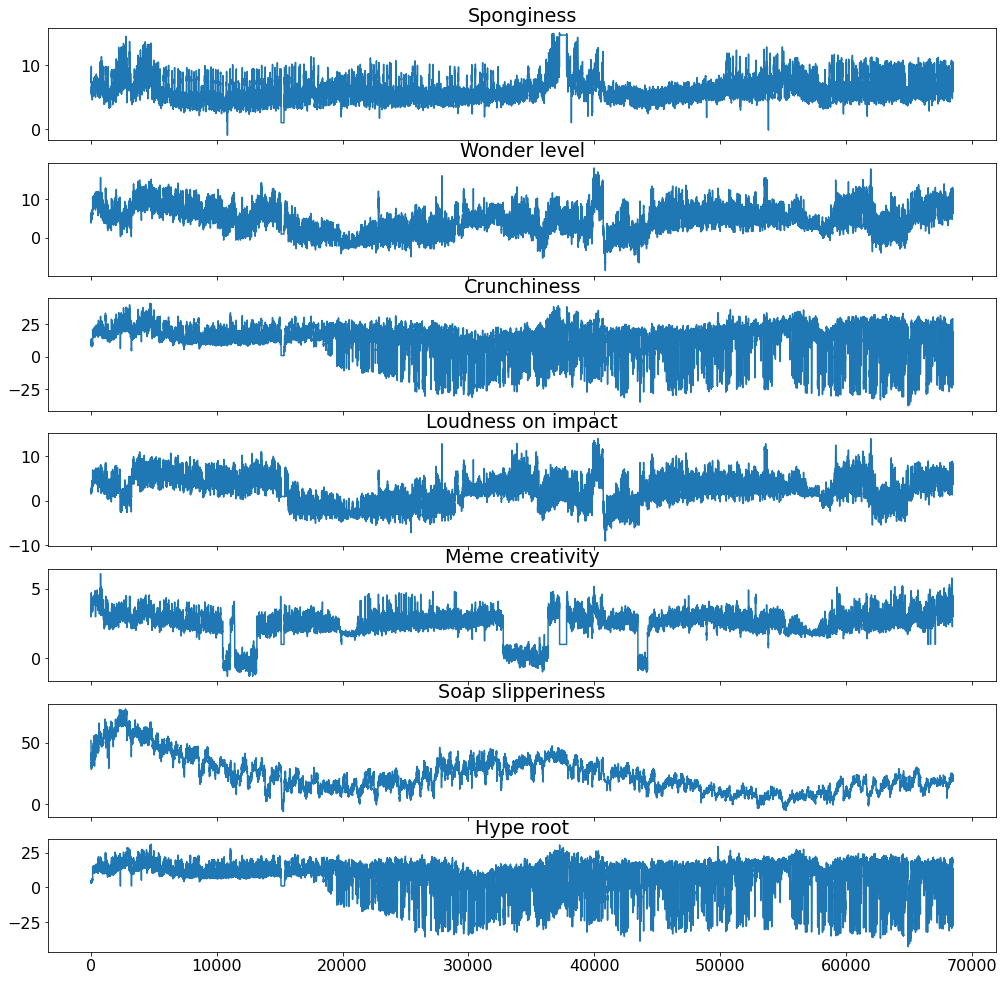

In [9]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [10]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(65102, 7) (3426, 7)


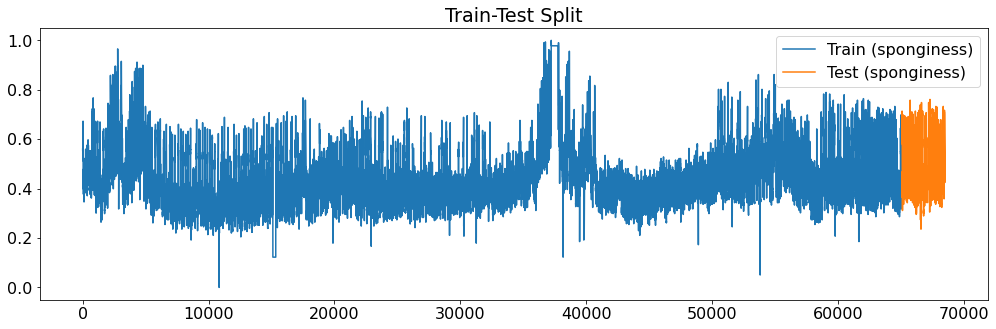

In [11]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [12]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1000, 7)

In [44]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values
    padding_len = len(df) % window

    if(padding_len != 0):
        # Compute padding length
        temp_df = temp_df[padding_len:]
        temp_label = temp_label[padding_len:]
        # padding_len = window - len(df)%window
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_df = np.concatenate((padding,df))
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_label = np.concatenate((padding,temp_label))
        # assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
      if len(df.shape) > 1:
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])
      else:
        dataset.append([[i] for i in temp_df[idx:idx+window]])
        labels.append([[i] for i in temp_label[idx+window:idx+window+telescope]])

    dataset = np.array(dataset)
    print(dataset.shape)
    labels = np.array(labels)

    return dataset, labels

In [45]:
target_labels = dataset.columns

In [46]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(6372, 1000, 7)
(172, 1000, 7)


((6372, 1000, 7), (6372, 288, 7), (172, 1000, 7), (172, 288, 7))

In [47]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

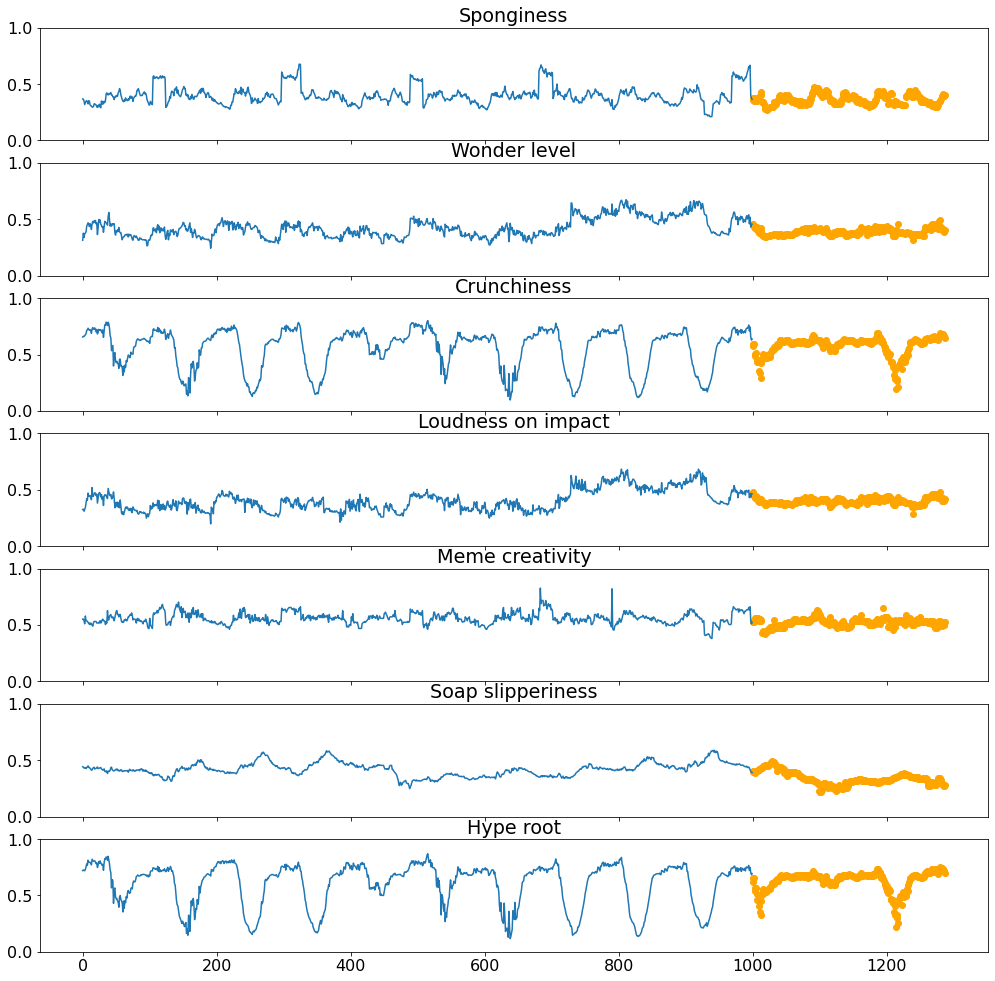

In [49]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape


((1000, 7), (288, 7))

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]
    # E2D2
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(200,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(200, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
    #
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
    model_e2d2.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e2d2

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 7)]    0           []                               
                                                                                                  
 lstm_15 (LSTM)                 [(None, 1000, 200),  166400      ['input_5[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 lstm_16 (LSTM)                 [(None, 200),        320800      ['lstm_15[0][0]']                
                                 (None, 200),                                               

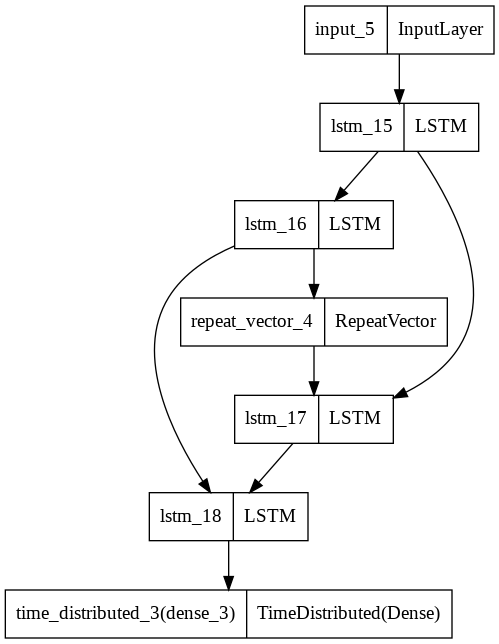

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5),
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/400
21/21 [==============================] - 39s 2s/step - loss: 0.0465 - mae: 0.1552 - val_loss: 0.0217 - val_mae: 0.1136 - lr: 0.0010
Epoch 2/400
21/21 [==============================] - 30s 1s/step - loss: 0.0145 - mae: 0.0893 - val_loss: 0.0172 - val_mae: 0.0932 - lr: 0.0010
Epoch 3/400
21/21 [==============================] - 30s 1s/step - loss: 0.0121 - mae: 0.0798 - val_loss: 0.0161 - val_mae: 0.0884 - lr: 0.0010
Epoch 4/400
21/21 [==============================] - 30s 1s/step - loss: 0.0114 - mae: 0.0766 - val_loss: 0.0155 - val_mae: 0.0857 - lr: 0.0010
Epoch 5/400
21/21 [==============================] - 30s 1s/step - loss: 0.0109 - mae: 0.0745 - val_loss: 0.0153 - val_mae: 0.0878 - lr: 0.0010
Epoch 6/400
21/21 [==============================] - 30s 1s/step - loss: 0.0105 - mae: 0.0732 - val_loss: 0.0157 - val_mae: 0.0895 - lr: 0.0010
Epoch 7/400
21/21 [==============================] - 30s 1s/step - loss: 0.0103 - mae: 0.0728 - val_loss: 0.0150 - val_mae: 0.0863 - lr:

In [ ]:
model.save(model_path)

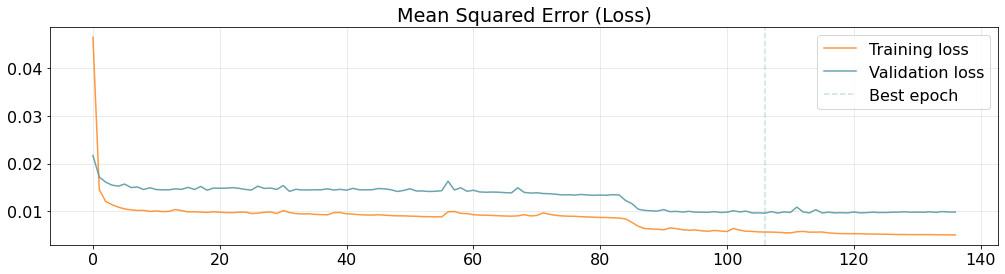

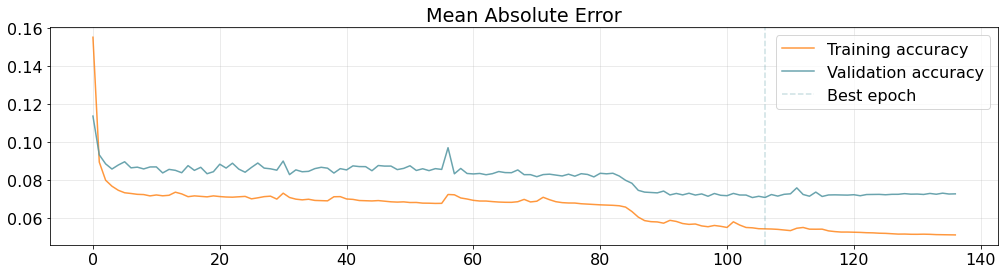

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

In [ ]:
# model = tfk.models.load_model(model_path)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(272, 288, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.008968762>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.069719456>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

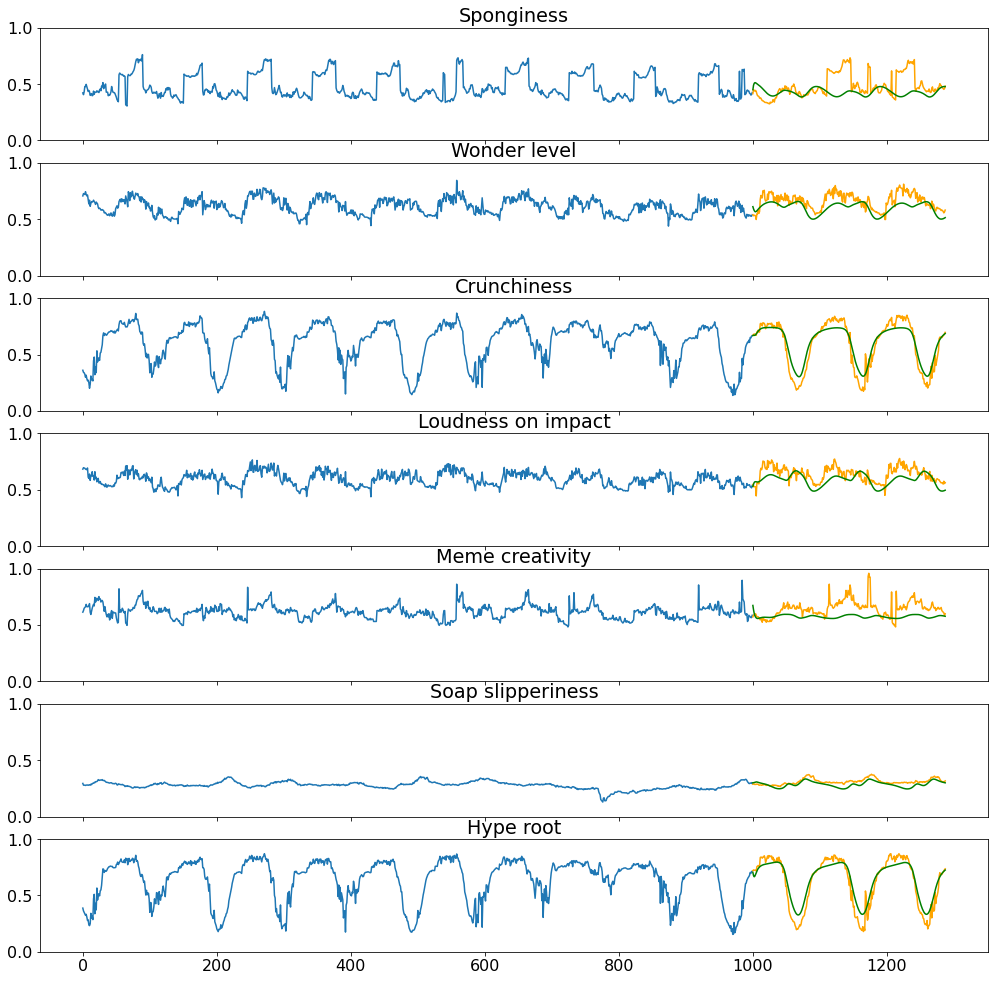

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

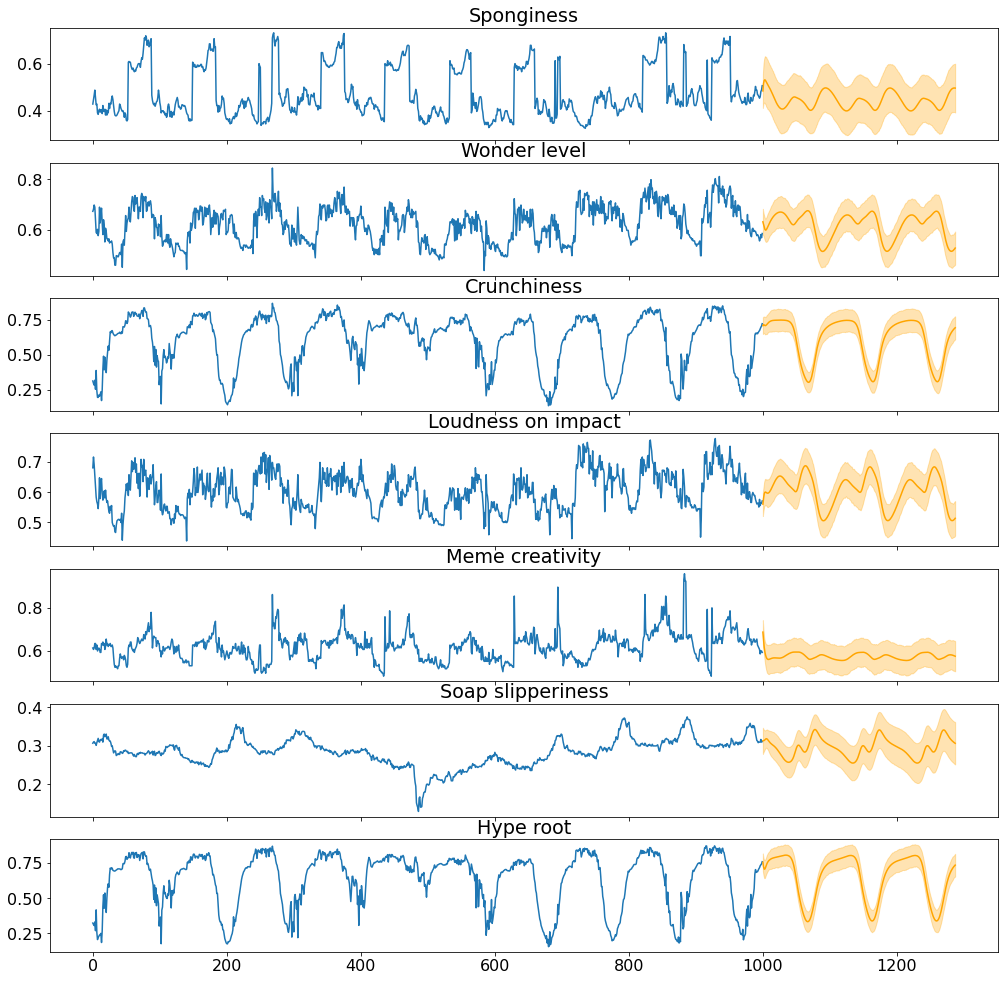

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((214, 1000, 7), (214, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
avgwin = 3
X = X_test_reg
a = int(np.floor(avgwin / 2))
reg_predictions_averaged = np.zeros(shape=(reg_predictions.shape))
for i,x1 in enumerate(reg_predictions):
  for j,x2 in enumerate(x1.T):
    for k,x in enumerate(x2):
      if k < a:
        reg_predictions_averaged[i,k,j] = sum(np.concatenate((X[i,-(a - k) :,j], reg_predictions[i,: (a + k + 1),j])))/(avgwin)
      elif x2.size - k <= a:
        reg_predictions_averaged[i,k,j] = sum(reg_predictions[i,-(x2.size - k + a) :,j])/(reg_predictions[i,-(x2.size - k + a):,j].size)
      else:
        reg_predictions_averaged[i,k,j] = sum(reg_predictions[i,k - a : k + a + 1,j])/(avgwin)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.010471291>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.077648915>)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions_averaged.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions_averaged.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=0.010456805650216791>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.07758947339535166>)

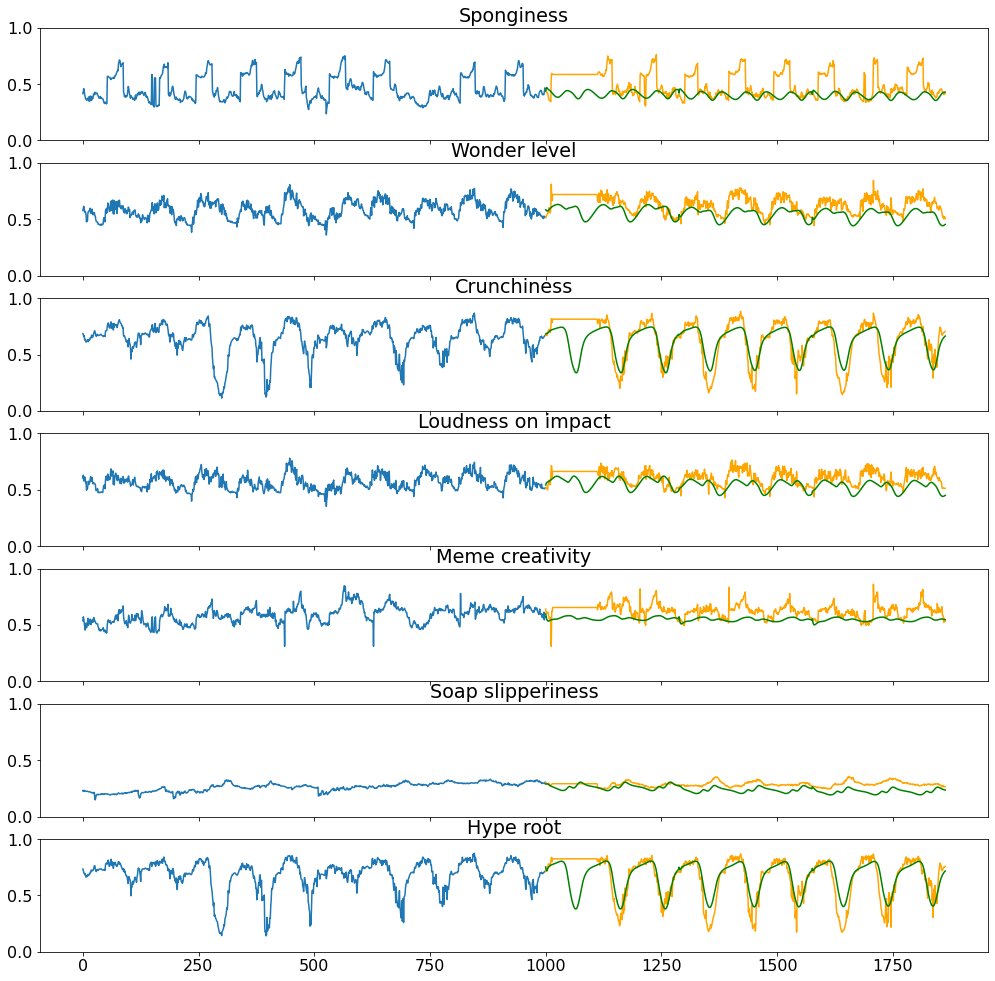

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

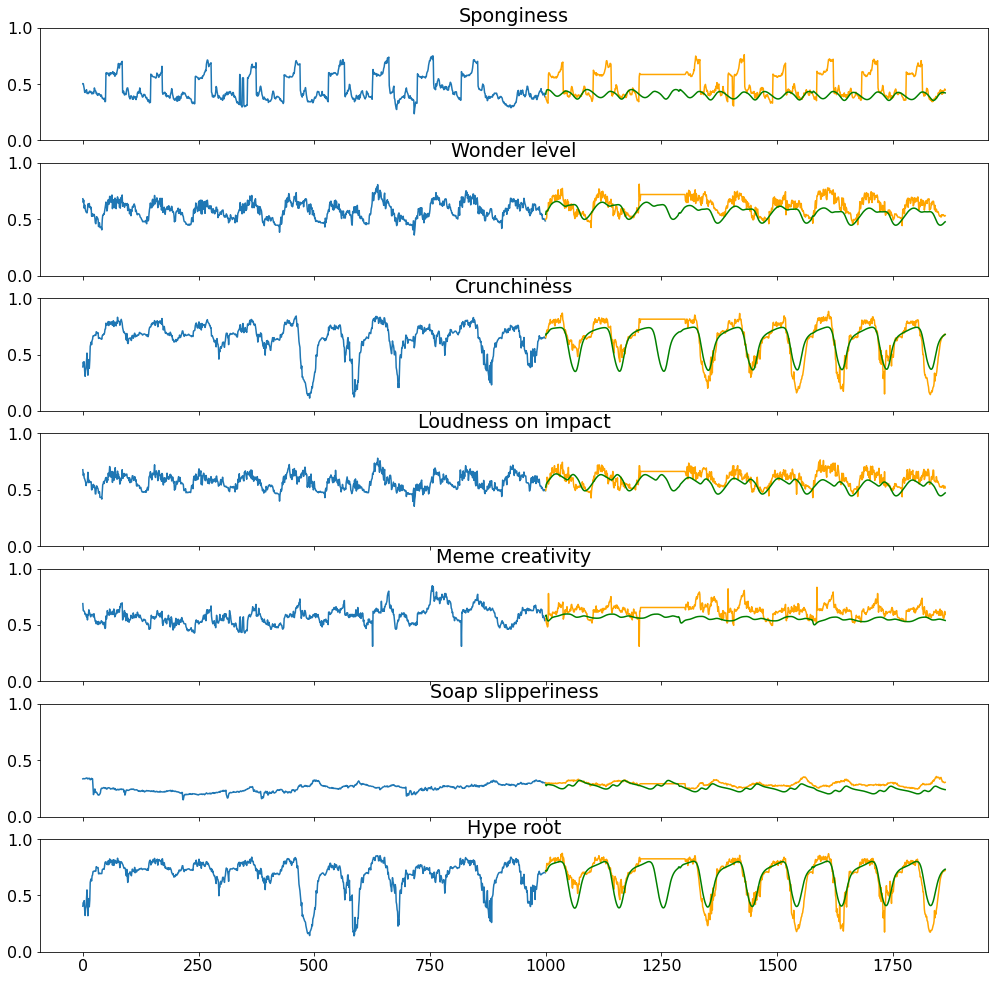

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions_averaged, target_labels, reg_telescope)

In [ ]:
print(X_max)
print(X_min)

Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64


In [ ]:
for a in X_max:
  print("{:.32f}".format(a))
print()
for a in X_min:
  print("{:.32f}".format(a))


15.10668024063110514987329224823043
18.12289930343628086006901867222041
41.13880050659178522209913353435695
14.03598027229309153085523576010019
6.05636000633239746093750000000000
77.37161994934081121755298227071762
31.02441982269287734652607468888164

-0.97207993984222407224393691649311
-8.45037973403930742222200933611020
-37.58172096252441463093418860808015
-9.02805981636046617211377451894805
-1.27586008548736540291201890795492
-6.00686032295226901567275490378961
-42.76922096252441463093418860808015


In [4]:
import numpy as np
a = np.array([
  15.10668024063110514987329224823043,
  18.12289930343628086006901867222041,
  41.13880050659178522209913353435695,
  14.03598027229309153085523576010019,
  6.05636000633239746093750000000000,
  77.37161994934081121755298227071762,
  31.02441982269287734652607468888164
])

In [5]:
for b in a:
  print(b)

15.106680240631105
18.12289930343628
41.138800506591785
14.035980272293092
6.0563600063323975
77.37161994934081
31.024419822692877
